In [3]:
from scipy.stats import chi2_contingency, mode, ttest_ind
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import seaborn as sns
from optbinning import BinningProcess
from sklearn.model_selection import train_test_split

In [14]:
df = pd.read_pickle(r'..\data\df_processed.pkl')
df.head()

,payFrequency,apr,nPaidOff,loanAmount,state,leadType,leadCost,labelTarget
0,B,360.0,0.0,500.0,IL,bvMandatory,6,0
1,B,199.0,0.0,3000.0,CA,prescreen,0,0
2,B,590.0,0.0,400.0,MO,bvMandatory,3,0
3,B,360.0,0.0,500.0,IL,bvMandatory,3,0
4,B,590.0,0.0,350.0,NV,bvMandatory,3,1


# A. Exploratory Data Analysis

## 1. Data Shape

In [4]:
df.shape

(577423, 8)

## 2. Data Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577423 entries, 0 to 577425
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   payFrequency  577423 non-null  object 
 1   apr           577423 non-null  float64
 2   nPaidOff      577423 non-null  float64
 3   loanAmount    577423 non-null  float64
 4   state         577423 non-null  object 
 5   leadType      577423 non-null  object 
 6   leadCost      577423 non-null  int64  
 7   labelTarget   577423 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 39.6+ MB


## 3. Missing Value

In [8]:
df.isnull().sum()

payFrequency    0
apr             0
nPaidOff        0
loanAmount      0
state           0
leadType        0
leadCost        0
labelTarget     0
dtype: int64

## 4. Pay Frequency Distribution

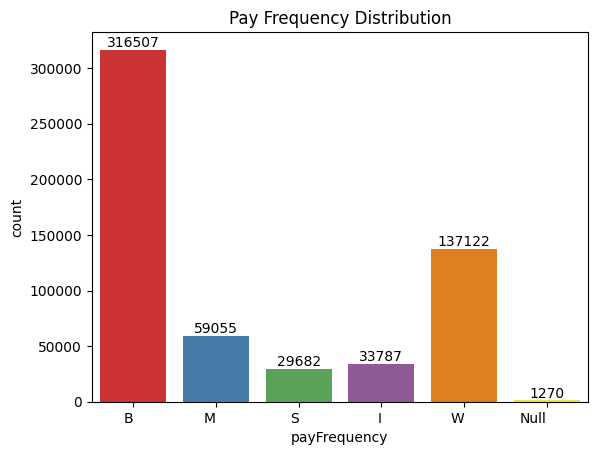

In [19]:
plt.title("Pay Frequency Distribution")
payFrequency_distribution = sns.countplot(
    data=df, x="payFrequency", hue="payFrequency", palette='Set1', legend=False)
for container in payFrequency_distribution.containers:
    payFrequency_distribution.bar_label(container)
for item in payFrequency_distribution.get_xticklabels():
    item.set_horizontalalignment('right')
plt.show()

## 5. Annual Percentage Rate Distribution

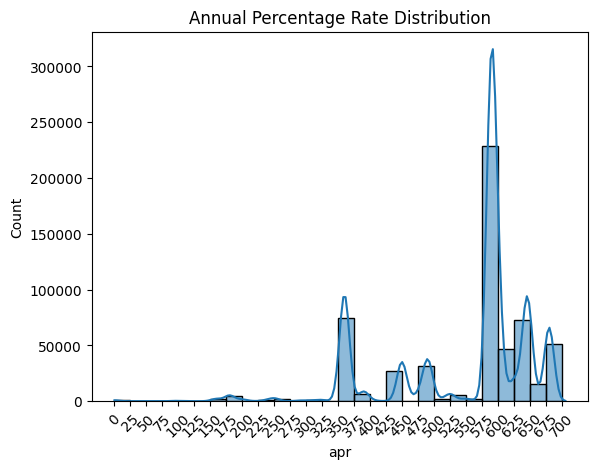

In [21]:
plt.title("Annual Percentage Rate Distribution")
apr_bins = np.arange(df["apr"].min(), df["apr"].max(), 25)
apr_plot = sns.histplot(data = df,
                        x = "apr",
                        bins = apr_bins,
                        kde = True)
apr_plot.set_xticks(apr_bins)
plt.xticks(rotation = 45)
plt.show()

## 6. Loan Amount Distribution

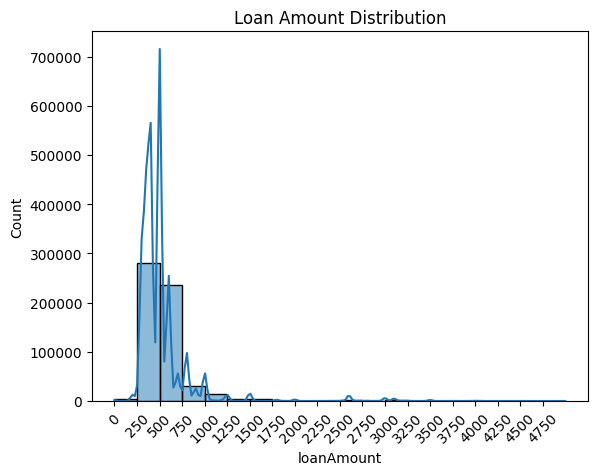

In [26]:
plt.title("Loan Amount Distribution")
loanAmount_bins = np.arange(df["loanAmount"].min(), df["loanAmount"].max(), 250)
loanAmount_plot = sns.histplot(data = df,
                               x = "loanAmount",
                               bins = loanAmount_bins,
                               kde = True)
loanAmount_plot.set_xticks(loanAmount_bins)
plt.xticks(rotation = 45)
plt.show()

## 7. Distribution of Loans by State

In [27]:
state_counts = df["state"].value_counts().reset_index()
state_counts.columns = ["state", "count"]
fig = px.choropleth(state_counts,
                    locations="state",
                    locationmode='USA-states',
                    color="count",
                    scope='usa',
                    color_continuous_scale='viridis',
                    title="Distribution of Loans by State"
)
fig.update_layout(autosize = False, width = 1000, height = 800)
fig.show()

## 8. Lead Type Distribution

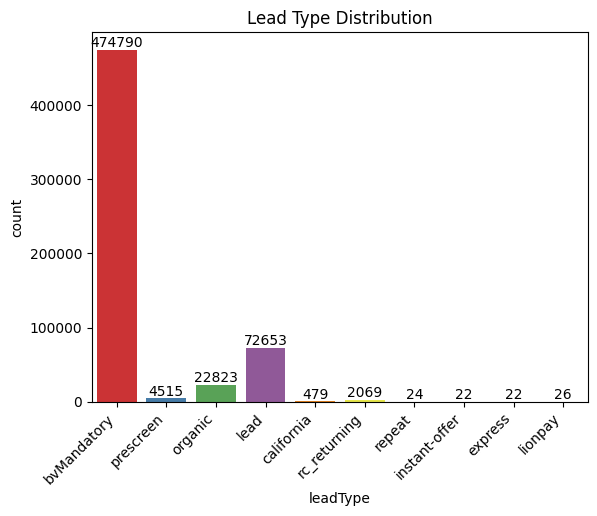

In [28]:
plt.title("Lead Type Distribution")
leadType_distribution = sns.countplot(
    data=df, x="leadType", hue="leadType", palette='Set1', legend=False)
for container in leadType_distribution.containers:
    leadType_distribution.bar_label(container)
for item in leadType_distribution.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')
plt.show()

## 9. Lead Cost Distribution

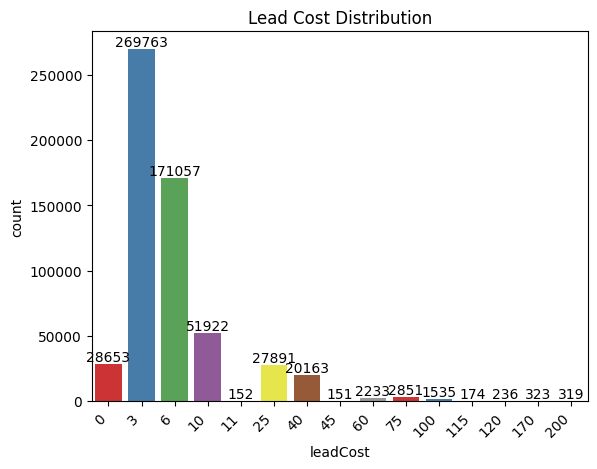

In [30]:
plt.title("Lead Cost Distribution")
leadCost_distribution = sns.countplot(
    data=df, x="leadCost", hue="leadCost", palette='Set1', legend=False)
for container in leadCost_distribution.containers:
    leadCost_distribution.bar_label(container)
for item in leadCost_distribution.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')
plt.show()

## 10. Target Label Proportion

Good Loans (Label = 0)  
Bad Loans (Label = 1)

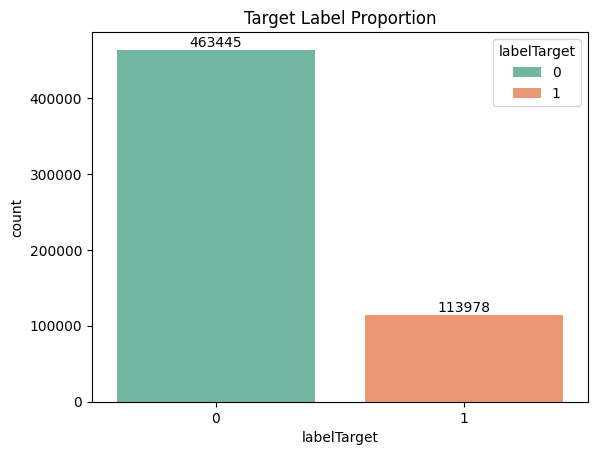

In [31]:
# Barplot
plt.title("Target Label Proportion")
y_proportion = sns.countplot(x=df["labelTarget"], hue=df["labelTarget"], palette='Set2')
for container in y_proportion.containers:
    y_proportion.bar_label(container)
plt.show()

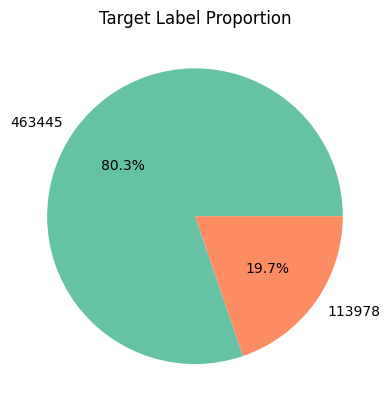

In [33]:
# Pie Chart
plt.title("Target Label Proportion")
plt.pie(x=df["labelTarget"].value_counts(),
        labels=df["labelTarget"].value_counts(),
        colors=sns.color_palette('Set2'),
        autopct='%1.1f%%')
plt.show()

# B. Statistical Analysis

## 1. Statistical Description

In [34]:
df.drop(columns=["labelTarget"]).describe()

,apr,nPaidOff,loanAmount,leadCost
count,577423.000000,577423.000000,577423.000000,577423.000000
mean,553.315851,0.037882,514.195446,7.854654
std,109.735301,0.333394,320.387005,12.853037
min,0.000000,0.000000,0.000000,0.000000
25%,490.000000,0.000000,350.000000,3.000000
50%,590.000000,0.000000,500.000000,3.000000
75%,601.000000,0.000000,500.000000,6.000000
max,705.590000,21.000000,5000.000000,200.000000


## 2. Skewness Analysis

In [35]:
numeric_columns = df.drop(columns=["labelTarget"]).select_dtypes(include=[np.number]).columns
df_processed_skewness = df[numeric_columns].skew()
df_processed_skewness = pd.DataFrame(
    {"variables": df_processed_skewness.index, "skewness": df_processed_skewness.values})

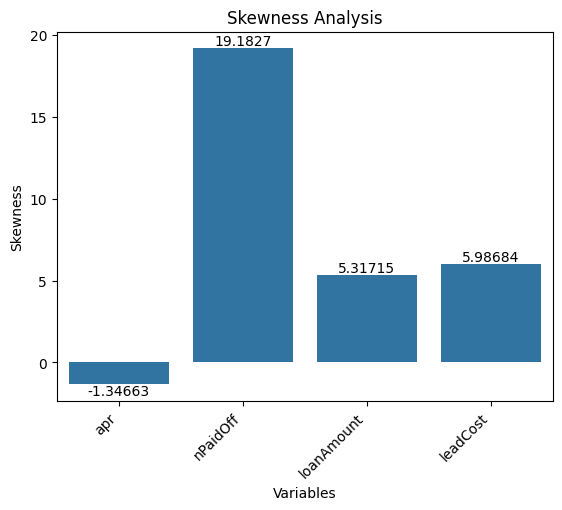

In [36]:
plt.title("Skewness Analysis")
skewness_plot = sns.barplot(x="variables", y="skewness", data=df_processed_skewness)
for container in skewness_plot.containers:
    skewness_plot.bar_label(container)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Variables")
plt.ylabel("Skewness")
plt.show()

From the skewness analysis visualization, the variable 'apr' has a negative skew, indicating that most values are on the higher end with a few lower outliers. In contrast, the variable 'nPaidOff' is heavily skewed toward zero, suggesting that most loans are from new users who have not previously taken loans.

## 3. Chi-Squared Analysis

In [37]:
df_categorical = df.drop(columns=["labelTarget"]).select_dtypes(include='object').copy()
df_numerical = df.drop(columns=["labelTarget"]).select_dtypes(include='number').copy()
df_categorical.shape, df_numerical.shape

((577423, 3), (577423, 4))

In [47]:
df_categorical.columns

Index(['payFrequency', 'state', 'leadType'], dtype='object')

In [49]:
df_numerical.columns

Index(['apr', 'nPaidOff', 'loanAmount', 'leadCost'], dtype='object')

In [50]:
chi2_list = []

for column in df_categorical.columns:
    cross_tab = pd.crosstab(df["labelTarget"], df_categorical[column])
    chi2, p_value, degree_of_freedom, expected_frequencies = chi2_contingency(
        cross_tab)
    chi2_list.append({"variables": column, "p-value": p_value})

chi2_result = pd.DataFrame(chi2_list)
chi2_result = chi2_result.sort_values(by="p-value", ascending=True)
chi2_result.reset_index(drop=True, inplace=True)
chi2_result

,variables,p-value
0,payFrequency,0.0
1,state,0.0
2,leadType,0.0


 Chi-Square analysis, which is used to assess the association between categorical variables and the target variable, reveals that 'payFrequency', 'state', and 'leadType' have p-values that are extremely close to 0, indicating significant associations with the target variable. These variables should be prioritized in the predictive modeling due to their strong statistical relevance.

## 4. T-Statistics Analysis

In [52]:
t_test_results = pd.DataFrame()

for variable in df_numerical.columns:
    group_0_values = df_numerical.loc[df["labelTarget"] == 0, variable]
    group_1_values = df_numerical.loc[df["labelTarget"] == 1, variable]
    t_statistic, p_value = ttest_ind(group_0_values, group_1_values)
    result_df = pd.DataFrame(
        {"variables": [variable], "t-statistic": [t_statistic], "p-value": [p_value]})
    t_test_results = pd.concat([t_test_results, result_df], ignore_index=True)

t_test_table = t_test_results.sort_values(by="t-statistic", ascending=False)
t_test_table.reset_index(drop=True, inplace=True)
t_test_table

,variables,t-statistic,p-value
0,leadCost,35.307329,8.884055e-273
1,apr,8.612934,7.138838e-18
2,loanAmount,-24.994343,8.343686e-138
3,nPaidOff,-30.770529,9.583962e-208


- The t-statistics analysis, which is used to compare the means of two groups to see if they are significantly different, shows that 'leadCost' exhibits the strongest difference between groups, with a t-statistic of approximately 35.31 and an almost zero p-value, indicating that it is a highly important predictor.
- 'loanAmount' and 'nPaidOff' have negative t-statistics, suggesting they are lower in one group, with all p-values close to zero, indicating their significance.
- 'apr' has a positive t-statistic, indicating it is higher in one group and is also statistically significant.

## 5. ANOVA F Analysis

In [53]:
f_statistic, p_values = f_classif(df_numerical, df["labelTarget"])

anova_f_table = pd.DataFrame({"variables": df_numerical.columns,
                              "f-score": f_statistic, "p-value": p_values})
anova_f_table.sort_values(by="f-score", ascending=False,
                          inplace=True, ignore_index=True)
anova_f_table

,variables,f-score,p-value
0,leadCost,1246.607466,8.884055e-273
1,nPaidOff,946.825480,9.583962e-208
2,loanAmount,624.717185,8.343686e-138
3,apr,74.182636,7.138838e-18


- The ANOVA (Analysis of Variance) analysis, which is used to determine whether there are statistically significant differences between the means of three or more groups, further confirms that 'leadCost' is the most significant predictor, with the highest F-score of approximately 1246.56 and a near-zero p-value, supporting our previous findings from the t-statistics analysis.
- 'nPaidOff', and 'loanAmount' also have very high F-scores, reaffirming their strong importance in explaining the target variable.
- While 'apr' is significant, it has a lower F-score compared to the others, making it less influential. Although we may consider excluding this variable, we will retain it for the time being.

## 6. Correlation Analysis

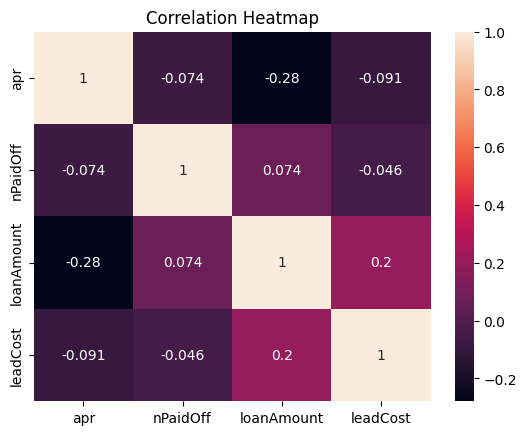

In [56]:
corr_matrix = df_numerical.corr()
plt.title("Correlation Heatmap")
sns.heatmap(data=corr_matrix, annot=True)
plt.show()

- 'loanAmount' and 'leadCost' have a moderate correlation of 0.2, these suggest some relationship but are not strong enough to raise concerns about multicollinearity.
- Most other variable pairs, such as 'apr' with others, show low to negligible correlations, indicating that they are more independent of each other.


# C. Feature Engineering

## 1. Data Splitting

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["labelTarget"]), df["labelTarget"], test_size=0.3, random_state=777, stratify=df["labelTarget"])

After data splitting, we suspect that some columns may contain categories that exist exclusively in either the training set or the test set. We will investigate this further to ensure consistency across both sets.

In [62]:
categorical_columns = df.select_dtypes(include='object').columns
category_check = {}

for column in categorical_columns:
    train_categories = set(X_train[column].unique())
    test_categories = set(X_test[column].unique())
    only_in_train = train_categories - test_categories
    only_in_test = test_categories - train_categories
    category_check[column] = {
        "Only in Train": only_in_train,
        "Only in Test": only_in_test
    }

category_check_df = pd.DataFrame(category_check).T
category_check_df

,Only in Train,Only in Test
payFrequency,{},{}
state,{},{}
leadType,{},{}


After checking, we confirmed that our dataset is well-distributed, allowing us to proceed with feature engineering.

In [74]:
total_samples = X_train.shape[0] + X_test.shape[0]

data = {
    'Dataset': ['X_train', 'X_test'],
    'Shape': [X_train.shape, X_test.shape],
    'Samples': [X_train.shape[0], X_test.shape[0]],
    'Percentage of Total (%)': [(X_train.shape[0] / total_samples) * 100, 
                                 (X_test.shape[0] / total_samples) * 100]
}

summary_df = pd.DataFrame(data)

summary_df

,Dataset,Shape,Samples,Percentage of Total (%)
0,X_train,"(404196, 7)",404196,69.999983
1,X_test,"(173227, 7)",173227,30.000017


In [73]:
total_y_train = y_train.shape[0]
total_y_test = y_test.shape[0]

y_data = {
    'Dataset': ['y_train', 'y_test'],
    'Shape': [y_train.shape, y_test.shape],
    'Class 0': [y_train.value_counts()[0], y_test.value_counts()[0]],
    'Class 0 Percentage (%)': [(y_train.value_counts()[0] / total_y_train) * 100, 
                               (y_test.value_counts()[0] / total_y_test) * 100],
    'Class 1': [y_train.value_counts()[1], y_test.value_counts()[1]],
    'Class 1 Percentage (%)': [(y_train.value_counts()[1] / total_y_train) * 100, 
                               (y_test.value_counts()[1] / total_y_test) * 100]
}

y_df = pd.DataFrame(y_data)

y_df

,Dataset,Shape,Class 0,Class 0 Percentage (%),Class 1,Class 1 Percentage (%)
0,y_train,"(404196,)",324411,80.260814,79785,19.739186
1,y_test,"(173227,)",139034,80.261160,34193,19.738840


## 2. Feature Optimal Binning

Using the optbinning library to calculate the Information Value (IV) and then encode our data using Weight of Evidence (WoE) before proceeding with modeling. Although we could create additional features by combining several columns, we will not pursue this due to time constraints. Instead, we aim to keep our initial model as close to the real data as possible.

In [75]:
feature = list(X_train.columns)
categorical_feature = ["payFrequency", "state", "leadType"]
X = X_train[feature]
y = y_train.values
selection_criteria = {
    "iv": {
        "min": 0.02,
        "max": 0.5,
        "strategy": "highest"
    }
}

In [76]:
optimal_binning_process = BinningProcess(
    feature, categorical_variables=categorical_feature, selection_criteria=selection_criteria)
optimal_binning_process.fit(X, y)

BinningProcess(categorical_variables=['payFrequency', 'state', 'leadType'],
               selection_criteria={'iv': {'max': 0.5, 'min': 0.02,
                                          'strategy': 'highest'}},
               variable_names=['payFrequency', 'apr', 'nPaidOff', 'loanAmount',
                               'state', 'leadType', 'leadCost'])

In [77]:
optimal_binning_process.information(print_level=2)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                          no   * d
    max_bin_size                          no   * d
    max_pvalue                            no   * d
    max_pvalue_policy            consecutive   * d
    selection_criteria                   yes   * U
    fixed_variables                       no   * d
    categorical_variables                yes   * U
    special_codes                         no   * d
    split_digits                          no   * d
    binning_fit_params                    no   * d
    binning_transform_params              no   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                 4041

In [78]:
optimal_binning_process.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,payFrequency,categorical,OPTIMAL,False,5,1.158601,0.095833,0.308863,0.048516
1,apr,numerical,OPTIMAL,False,5,0.002135,0.000267,0.02311,0.006965
2,nPaidOff,numerical,OPTIMAL,False,1,0.0,0.0,0,0.0
3,loanAmount,numerical,OPTIMAL,True,6,0.068108,0.008466,0.141279,0.256837
4,state,categorical,OPTIMAL,True,11,0.030133,0.003745,0.089324,0.006647
5,leadType,categorical,OPTIMAL,True,2,0.025617,0.003178,0.049992,0.031408
6,leadCost,numerical,OPTIMAL,True,3,0.023419,0.002908,0.056553,0.039106


As observed from the optimal binning process, several columns have Information Value (IV) values outside our desired range: `payFrequency`, `apr`, `nPaidOff`. We will exclude these columns from our modeling.

## 3. Optimal Binning Details

### 3.1 payFrequency Optimal Binning Details

In [79]:
optb = optimal_binning_process.get_binned_variable("payFrequency")
optimal_binning_table_payFrequency = optb.binning_table.build()
optimal_binning_table_payFrequency.insert(0, "Variables", "payFrequency")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Null, M]",42182,0.104360,36696,5486,0.130055,0.497793,0.022080,0.002732
1,[B],221748,0.548615,189226,32522,0.146662,0.35835,0.062951,0.007827
2,[W],95755,0.236902,79939,15816,0.165172,0.217566,0.010482,0.001308
3,[S],20829,0.051532,16816,4013,0.192664,0.030116,0.000046,0.000006
4,[I],23682,0.058590,1734,21948,0.926780,-3.940921,1.063041,0.083961
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,404196,1.000000,324411,79785,0.197392,,1.158601,0.095833


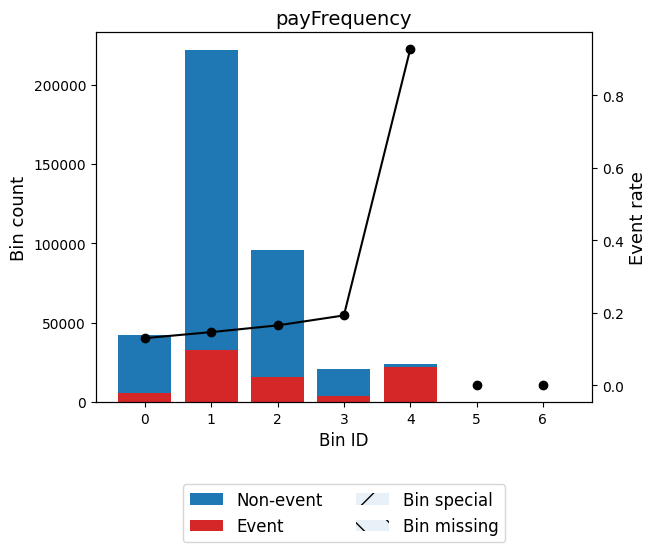

In [80]:
optb.binning_table.plot(metric="event_rate")

### 3.2 apr Optimal Binning Details

In [81]:
optb = optimal_binning_process.get_binned_variable("apr")
optimal_binning_table_apr = optb.binning_table.build()
optimal_binning_table_apr.insert(0, "Variables", "apr")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 449.49)",68827,0.170281,54543,14284,0.207535,-0.062826,0.000685,0.000086
1,"[449.49, 597.94)",204520,0.505992,163814,40706,0.199032,-0.01032,0.000054,0.000007
2,"[597.94, 618.95)",32971,0.081572,26692,6279,0.190440,0.044477,0.000159,0.000020
3,"[618.95, 655.00)",61994,0.153376,50623,11371,0.183421,0.090664,0.001226,0.000153
4,"[655.00, inf)",35884,0.088779,28739,7145,0.199114,-0.010833,0.000010,0.000001
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,404196,1.000000,324411,79785,0.197392,,0.002135,0.000267


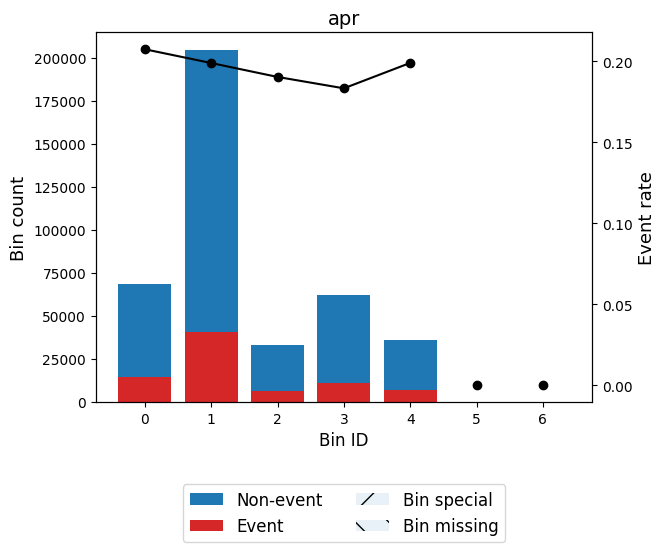

In [82]:
optb.binning_table.plot(metric="event_rate")

### 3.3 nPaidOff Optimal Binning Details

In [83]:
optb = optimal_binning_process.get_binned_variable("nPaidOff")
optimal_binning_table_nPaidOff = optb.binning_table.build()
optimal_binning_table_nPaidOff.insert(0, "Variables", "nPaidOff")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",404196,1.0,324411,79785,0.197392,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,404196,1.0,324411,79785,0.197392,,0.0,0.0


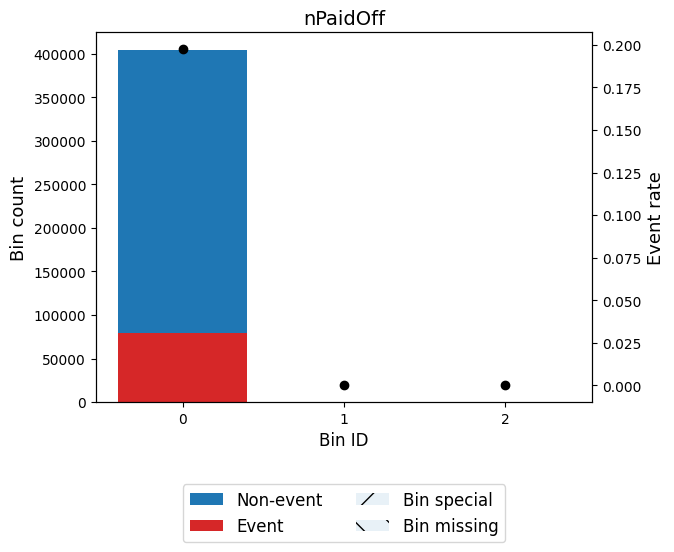

In [84]:
optb.binning_table.plot(metric="event_rate")

### 3.4 loanAmount Optimal Binning Details

In [85]:
optb = optimal_binning_process.get_binned_variable("loanAmount")
optimal_binning_table_loanAmount = optb.binning_table.build()
optimal_binning_table_loanAmount.insert(0, "Variables", "loanAmount")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 302.50)",46816,0.115825,36020,10796,0.230605,-0.197777,0.004802,0.000599
1,"[302.50, 370.50)",62602,0.154880,49680,12922,0.206415,-0.056005,0.000494,0.000062
2,"[370.50, 493.50)",88705,0.219460,71338,17367,0.195784,0.010182,0.000023,0.000003
3,"[493.50, 500.50)",113850,0.281670,97918,15932,0.139939,0.413125,0.042199,0.005238
4,"[500.50, 601.50)",41192,0.101911,31201,9991,0.242547,-0.26391,0.007666,0.000955
5,"[601.50, inf)",51031,0.126253,38254,12777,0.250377,-0.306074,0.012924,0.001609
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,404196,1.000000,324411,79785,0.197392,,0.068108,0.008466


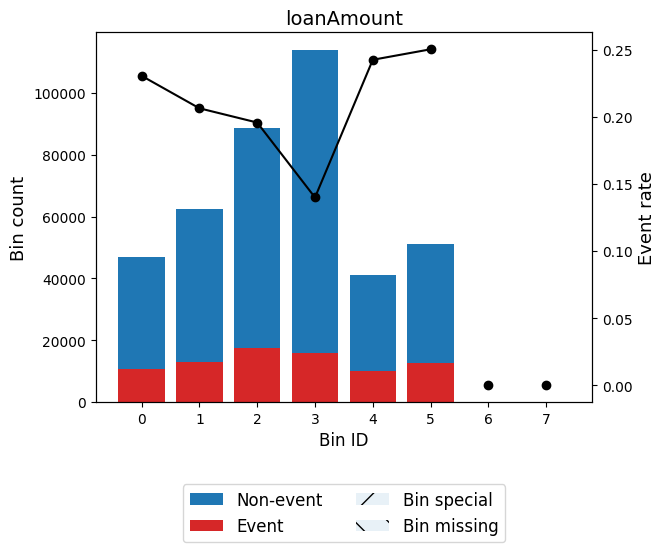

In [86]:
optb.binning_table.plot(metric="event_rate")

### 3.5 state Optimal Binning Details

In [87]:
optb = optimal_binning_process.get_binned_variable("state")
optimal_binning_table_state = optb.binning_table.build()
optimal_binning_table_state.insert(0, "Variables", "state")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[NY, MD, SD, IN, ND, MO]",54163,0.134002,45110,9053,0.167144,0.203332,0.005202,6.491523e-04
1,"[MI, NM, MS]",29061,0.071898,24055,5006,0.172258,0.16703,0.001905,2.378695e-04
2,[WI],28268,0.069936,23149,5119,0.181088,0.106317,0.000765,9.560130e-05
3,"[TN, PA]",29936,0.074063,24403,5533,0.184828,0.0813,0.000478,5.967422e-05
4,"[IL, AL, UT]",54316,0.134380,44141,10175,0.187330,0.06478,0.000553,6.909817e-05
5,"[KY, NC]",21008,0.051975,16961,4047,0.192641,0.030265,0.000047,5.896246e-06
6,"[KS, OH]",64174,0.158770,51773,12401,0.193240,0.026416,0.000110,1.373770e-05
7,"[NE, SC, LA, HI, WY, OK, IA]",23273,0.057579,18660,4613,0.198213,-0.005172,0.000002,1.928205e-07
8,"[GA, RI, MN, CO, TX]",40480,0.100149,31645,8835,0.218256,-0.126817,0.001673,2.089345e-04
9,"[FL, NJ, DE, ID, AK, AZ, WA, NV]",36099,0.089311,27794,8305,0.230062,-0.194713,0.003586,4.475470e-04


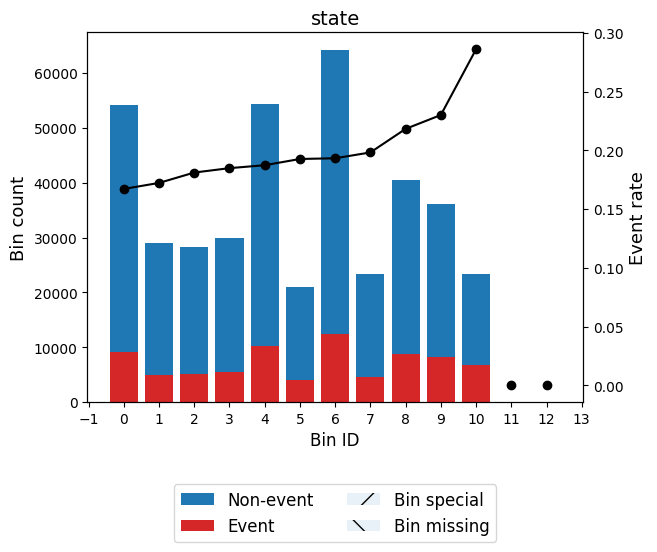

In [88]:
optb.binning_table.plot(metric="event_rate")

### 3.6 leadType Optimal Binning Details

In [89]:
optb = optimal_binning_process.get_binned_variable("leadType")
optimal_binning_table_leadType = optb.binning_table.build()
optimal_binning_table_leadType.insert(0, "Variables", "leadType")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[california, lead, repeat]",51179,0.126619,44278,6901,0.134840,0.456146,0.022804,0.002826
1,"[organic, bvMandatory, lionpay, prescreen, exp...",353017,0.873381,280133,72884,0.206460,-0.05628,0.002814,0.000352
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,404196,1.000000,324411,79785,0.197392,,0.025617,0.003178


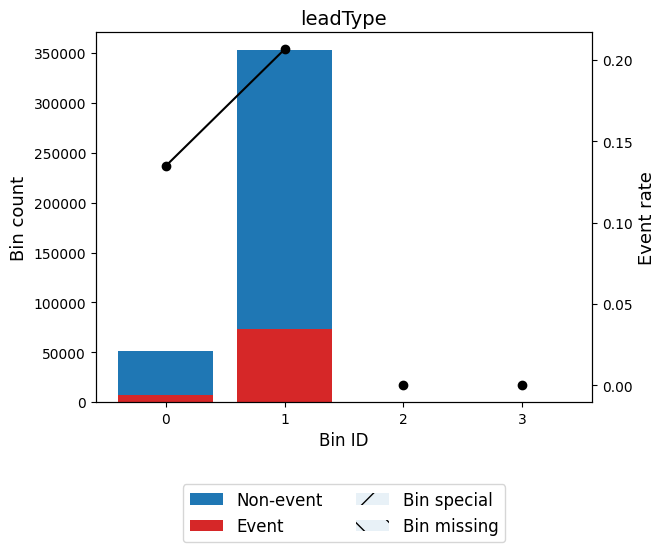

In [90]:
optb.binning_table.plot(metric="event_rate")

### 3.7 leadCost Optimal Binning Details

In [91]:
optb = optimal_binning_process.get_binned_variable("leadCost")
optimal_binning_table_leadCost = optb.binning_table.build()
optimal_binning_table_leadCost.insert(0, "Variables", "leadCost")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8.00)",328699,0.813217,262977,65722,0.199946,-0.016043,0.000210,0.000026
1,"[8.00, 18.00)",36415,0.090092,27651,8764,0.240670,-0.253666,0.006243,0.000778
2,"[18.00, inf)",39082,0.096691,33783,5299,0.135587,0.449764,0.016965,0.002103
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,404196,1.000000,324411,79785,0.197392,,0.023419,0.002908


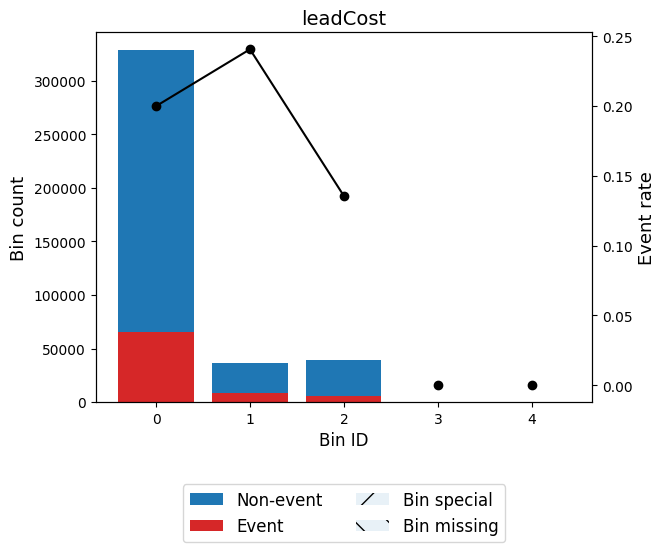

In [92]:
optb.binning_table.plot(metric="event_rate")

## 4. Optimal Binning Analysis

In [93]:
optimal_binning_table_dict = [
    optimal_binning_table_loanAmount, optimal_binning_table_state, optimal_binning_table_leadType, optimal_binning_table_leadCost]
optimal_binning_analysis = pd.concat(optimal_binning_table_dict, axis=0)
optimal_binning_analysis

,Variables,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,loanAmount,"(-inf, 302.50)",46816,0.115825,36020,10796,0.230605,-0.197777,0.004802,5.993180e-04
1,loanAmount,"[302.50, 370.50)",62602,0.154880,49680,12922,0.206415,-0.056005,0.000494,6.174532e-05
2,loanAmount,"[370.50, 493.50)",88705,0.219460,71338,17367,0.195784,0.010182,0.000023,2.835010e-06
3,loanAmount,"[493.50, 500.50)",113850,0.281670,97918,15932,0.139939,0.413125,0.042199,5.237715e-03
4,loanAmount,"[500.50, 601.50)",41192,0.101911,31201,9991,0.242547,-0.26391,0.007666,9.554428e-04
5,loanAmount,"[601.50, inf)",51031,0.126253,38254,12777,0.250377,-0.306074,0.012924,1.609205e-03
6,loanAmount,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
7,loanAmount,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,loanAmount,,404196,1.000000,324411,79785,0.197392,,0.068108,8.466262e-03
0,state,"[NY, MD, SD, IN, ND, MO]",54163,0.134002,45110,9053,0.167144,0.203332,0.005202,6.491523e-04


In [94]:
optimal_binning_analysis_dict = {
    "Non-event": "Good", "Event": "Bad", "Event rate": "Bad Rate"}
bin_to_remove = ["Special", "Missing"]
optimal_binning_analysis.rename(
    columns=optimal_binning_analysis_dict, inplace=True)
optimal_binning_analysis = optimal_binning_analysis[optimal_binning_analysis.Bin.isin(
    bin_to_remove) == False]
optimal_binning_analysis

,Variables,Bin,Count,Count (%),Good,Bad,Bad Rate,WoE,IV,JS
0,loanAmount,"(-inf, 302.50)",46816,0.115825,36020,10796,0.230605,-0.197777,0.004802,5.993180e-04
1,loanAmount,"[302.50, 370.50)",62602,0.154880,49680,12922,0.206415,-0.056005,0.000494,6.174532e-05
2,loanAmount,"[370.50, 493.50)",88705,0.219460,71338,17367,0.195784,0.010182,0.000023,2.835010e-06
3,loanAmount,"[493.50, 500.50)",113850,0.281670,97918,15932,0.139939,0.413125,0.042199,5.237715e-03
4,loanAmount,"[500.50, 601.50)",41192,0.101911,31201,9991,0.242547,-0.26391,0.007666,9.554428e-04
5,loanAmount,"[601.50, inf)",51031,0.126253,38254,12777,0.250377,-0.306074,0.012924,1.609205e-03
Totals,loanAmount,,404196,1.000000,324411,79785,0.197392,,0.068108,8.466262e-03
0,state,"[NY, MD, SD, IN, ND, MO]",54163,0.134002,45110,9053,0.167144,0.203332,0.005202,6.491523e-04
1,state,"[MI, NM, MS]",29061,0.071898,24055,5006,0.172258,0.16703,0.001905,2.378695e-04
2,state,[WI],28268,0.069936,23149,5119,0.181088,0.106317,0.000765,9.560130e-05


## 5. Feature Optimal Binning Weight of Evidence Encoding

In [95]:
X_train_woe = optimal_binning_process.transform(X, metric="woe")
X_test_woe = optimal_binning_process.transform(X_test[feature], metric="woe")
X_train_woe.shape, X_test_woe.shape

((404196, 4), (173227, 4))

In [96]:
X_train_woe.head()

,loanAmount,state,leadType,leadCost
102002,0.010182,0.081300,-0.056280,-0.253666
333218,0.010182,-0.126817,-0.056280,-0.016043
101606,-0.197777,0.064780,-0.056280,-0.016043
127334,-0.197777,0.167030,0.456146,-0.016043
220585,0.413125,0.203332,-0.056280,-0.016043


In [97]:
X_test_woe.head()

,loanAmount,state,leadType,leadCost
507159,0.010182,0.064780,-0.05628,-0.016043
375248,-0.056005,0.026416,-0.05628,-0.016043
371763,-0.306074,0.030265,-0.05628,-0.016043
312416,0.413125,0.167030,-0.05628,-0.016043
380330,-0.197777,0.203332,-0.05628,-0.016043


In [110]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173227 entries, 507159 to 280562
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   payFrequency  173227 non-null  object 
 1   apr           173227 non-null  float64
 2   nPaidOff      173227 non-null  float64
 3   loanAmount    173227 non-null  float64
 4   state         173227 non-null  object 
 5   leadType      173227 non-null  object 
 6   leadCost      173227 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 10.6+ MB


## 6. Export Data

In [98]:
with open('../models/optimal_binning_process.pkl', 'wb') as file:
    pickle.dump(optimal_binning_process, file)

X_train_woe.to_pickle('../data/processed/X_train_woe.pkl')
X_test_woe.to_pickle('../data/processed/X_test_woe.pkl')
y_train.to_pickle('../data/processed/y_train.pkl')
y_test.to_pickle('../data/processed/y_test.pkl')

# D. Model Training and Evaluation

In [2]:
from copy import deepcopy
from datetime import datetime
from hyperopt import fmin, tpe, space_eval, Trials, STATUS_OK
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, StratifiedKFold
from tqdm import tqdm
from xgboost import XGBClassifier
import hashlib
import hyperopt
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [4]:
X_train = pd.read_pickle('../data/processed/X_train_woe.pkl')
X_test = pd.read_pickle('../data/processed/X_test_woe.pkl')
y_train = pd.read_pickle('../data/processed/y_train.pkl')
y_test = pd.read_pickle('../data/processed/y_test.pkl')

## 1. Training Log

In [11]:
def time_stamp():
    return datetime.now()


def create_logger():
    return {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "performance": [],
        "f1_score_avg": [],
        "auc_roc": [],
        "gini": [],
        "data_configurations": []
    }


def training_log_updater(current_log, log_path):
    try:
        with open(log_path, 'r') as file:
            last_log = json.load(file)
    except FileNotFoundError:
        with open(log_path, 'w') as file:
            file.write("[]")
        with open(log_path, 'r') as file:
            last_log = json.load(file)
    last_log.append(current_log)
    with open(log_path, 'w') as file:
        json.dump(last_log, file)
    return last_log


def model_training_and_evaluation(model_factory, model_prefix, X_train, y_train, X_test, y_test, data_configuration, log_path):
    def check_log_length(log_path):
        try:
            with open(log_path, 'r') as file:
                logs = json.load(file)
                return len(logs)
        except FileNotFoundError:
            return 0
    before_training_len = check_log_length(log_path)
    logger = create_logger()
    current_training_models = []
    for model in tqdm(model_factory):
        model_name = model_prefix + "-" + model["model_name"]
        start_time = time_stamp()
        model["model_object"].fit(X_train, y_train)
        finished_time = time_stamp()
        elapsed_time = (finished_time - start_time).total_seconds()
        y_prediction = model["model_object"].predict(X_test)
        performance = classification_report(
            y_test, y_prediction, output_dict=True)
        y_probs = model["model_object"].predict_proba(X_test)[:, 1]
        auc_roc = roc_auc_score(y_test, y_probs)
        gini = 2 * auc_roc - 1
        original_id = str(start_time) + str(finished_time)
        hashed_id = hashlib.md5(original_id.encode()).hexdigest()
        model["model_uid"] = hashed_id
        logger["model_name"].append(model_name)
        logger["model_uid"].append(hashed_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["auc_roc"].append(auc_roc)
        logger["gini"].append(gini)
        logger["data_configurations"].append(data_configuration)
        current_training_models.append({
            "model_name": model_name,
            "model_object": deepcopy(model["model_object"]),
            "model_uid": model["model_uid"]
        })
    training_log = training_log_updater(logger, log_path)
    after_training_len = check_log_length(log_path)
    print(f"Logs Before Training: {before_training_len}")
    print(f"Logs After Training: {after_training_len}")
    print(f"Added {after_training_len - before_training_len} new logs.")
    return training_log, current_training_models


def model_training_and_evaluation_skf(model_factory, model_prefix, X_train, y_train, X_test, y_test, data_configuration, log_path, n_splits=5, datasets_per_fold=None):
    def check_log_length(log_path):
        try:
            with open(log_path, 'r') as file:
                logs = json.load(file)
                return len(logs)
        except FileNotFoundError:
            return 0
    before_training_len = check_log_length(log_path)
    logger = create_logger()
    X = pd.concat([X_train, X_test], axis=0)
    y = pd.concat([y_train, y_test], axis=0)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
    current_training_models = []
    if datasets_per_fold is None:
        datasets_per_fold = []
    for model in tqdm(model_factory()):
        for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
            model_name = f"{model_prefix}-{model['model_name']}-fold_{fold+1}"
            start_time = time_stamp()
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
            X_train_current, X_test_current = X_train_fold, X_val_fold
            fold_data_dict = {
                "model_name": model_name,
                "n_fold": f"fold_{fold+1}",
                "X_train": pd.DataFrame(X_train_fold),
                "y_train": pd.Series(y_train_fold),
                "X_test": pd.DataFrame(X_val_fold),
                "y_test": pd.Series(y_val_fold)
            }
            datasets_per_fold.append(fold_data_dict)
            model["model_object"].fit(X_train_current, y_train_fold)
            finished_time = time_stamp()
            elapsed_time = (finished_time - start_time).total_seconds()
            y_prediction = model["model_object"].predict(X_test_current)
            performance = classification_report(
                y_val_fold, y_prediction, output_dict=True)
            y_probs = model["model_object"].predict_proba(X_test_current)[:, 1]
            auc_roc = roc_auc_score(y_val_fold, y_probs)
            gini = 2 * auc_roc - 1
            original_id = str(start_time) + str(finished_time)
            hashed_id = hashlib.md5(original_id.encode()).hexdigest()
            model["model_uid"] = hashed_id
            logger["model_name"].append(model_name)
            logger["model_uid"].append(hashed_id)
            logger["training_time"].append(elapsed_time)
            logger["training_date"].append(str(start_time))
            logger["performance"].append(performance)
            logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
            logger["auc_roc"].append(auc_roc)
            logger["gini"].append(gini)
            logger["data_configurations"].append(data_configuration)
            current_training_models.append({
                "model_name": model_name,
                "model_object": deepcopy(model["model_object"]),
                "model_uid": model["model_uid"]
            })
    training_log = training_log_updater(logger, log_path)
    after_training_len = check_log_length(log_path)
    print(f"Logs Before Training: {before_training_len}")
    print(f"Logs After Training: {after_training_len}")
    print(f"Added {after_training_len - before_training_len} new logs.")
    return training_log, current_training_models, datasets_per_fold


def training_log_to_df_converter(training_log):
    all_training_logs_df = pd.DataFrame()
    for log in tqdm(training_log):
        individual_log_df = pd.DataFrame(log)
        performance_df = pd.json_normalize(individual_log_df["performance"])
        individual_log_df = pd.concat([individual_log_df.drop(
            "performance", axis=1), performance_df], axis=1)
        all_training_logs_df = pd.concat(
            [all_training_logs_df, individual_log_df])
    all_training_logs_df.sort_values(["f1_score_avg", "auc_roc", "training_time"], ascending=[
                                     False, False, True], inplace=True)
    all_training_logs_df.reset_index(inplace=True, drop=True)
    return all_training_logs_df


def best_model_finder(all_training_logs_df, models_list):
    model_object = None
    best_model_info = all_training_logs_df.iloc[0]
    for configuration_data in models_list:
        for model_data in models_list[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    return model_object

def tuned_model_finder(models_list_tuned, tuning_method):
    for model in models_list_tuned:
        if tuning_method in model["model_name"]:
            return model["model_object"]
    print(f"No model found that was tuned with {tuning_method}")
    return None

## 2. Baseline Models

We will train two models for A/B testing during our model training process. The models being compared are Logistic Regression and Extreme Gradient Boosting (XGBoost). We will select the best model based on their performance metrics.

In [23]:
def create_models(prefix):
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    return [
        {"model_name": prefix + "_LogisticRegression",
            "model_object": LogisticRegression(random_state=777, class_weight='balanced'), "model_uid": ""},
        {"model_name": prefix + "_XGBClassifier",
            "model_object": XGBClassifier(random_state=777, scale_pos_weight=scale_pos_weight), "model_uid": ""}
    ]

In [24]:
models_factory = {
    "vanilla": lambda: create_models("vanilla"),
}

In [25]:
models_factory

{'vanilla': <function __main__.<lambda>()>}

### 2.1 Vanilla Models

we will train our model using stratified k-fold cross-validation to identify the best model with the most suitable data configuration.

In [26]:
training_log, models_list_vanilla, datasets_per_fold_vanilla = model_training_and_evaluation_skf(
    models_factory["vanilla"],
    "vanilla",
    X_train,
    y_train,
    X_test,
    y_test,
    "vanilla",
    '../models/logs/training_log.json'
)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:08<00:00,  4.42s/it]

Logs Before Training: 0
Logs After Training: 1
Added 1 new logs.


In [27]:
models_list = {
    "vanilla": models_list_vanilla
}
models_list

{'vanilla': [{'model_name': 'vanilla-vanilla_LogisticRegression-fold_1',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': 'e63ae0dfc7b802fda2e8097728ffc75f'},
  {'model_name': 'vanilla-vanilla_LogisticRegression-fold_2',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': 'b955eab570f64b54d720a6e45c7123f5'},
  {'model_name': 'vanilla-vanilla_LogisticRegression-fold_3',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': '1a0700d2198e471f308cd45e966e51b4'},
  {'model_name': 'vanilla-vanilla_LogisticRegression-fold_4',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': '029d06903d7e5a99bac03aa4a451a3ad'},
  {'model_name': 'vanilla-vanilla_LogisticRegression-fold_5',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': 'e901609a5967055b316b6f188a239814'},
  {'

### 2.2 Models Selection

#### 2.2.1 Benchmark Performance Review

We will establish a benchmark for our models by evaluating the performance of a dummy model that always predicts the most common label. We will then compare this benchmark with the accuracy of our trained models to assess their effectiveness.

In [28]:
# Model performance that a model would achieve if it always predicted the most common label.
benchmark = y_train.value_counts(normalize=True)[0]
benchmark

np.float64(0.802608140605053)

#### 2.2.2 Baseline Base Model Performance Review

In [29]:
all_training_logs_df = training_log_to_df_converter(training_log)
all_training_logs_df

100%|██████████| 1/1 [00:00<00:00, 249.28it/s]


,model_name,model_uid,training_time,training_date,f1_score_avg,auc_roc,gini,data_configurations,accuracy,0.precision,...,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,vanilla-vanilla_XGBClassifier-fold_4,0c8cece672122af336c13a092d9c4806,1.105984,2024-08-15 12:42:56.456359,0.538970,0.616119,0.232239,vanilla,0.617549,0.844264,...,0.348637,22795.0,0.553431,0.580217,0.538970,115484.0,0.729451,0.617549,0.654165,115484.0
1,vanilla-vanilla_XGBClassifier-fold_1,7fbe64f6732fd6bd993e9cf2692b6b90,1.210205,2024-08-15 12:42:52.293107,0.533882,0.617268,0.234536,vanilla,0.606183,0.845707,...,0.350304,22796.0,0.552720,0.580422,0.533882,115485.0,0.730039,0.606183,0.644985,115485.0
2,vanilla-vanilla_XGBClassifier-fold_2,29f28fb76e20e0a6c16ea10b8b247212,1.207557,2024-08-15 12:42:53.709505,0.532142,0.615641,0.231283,vanilla,0.602606,0.846053,...,0.350574,22796.0,0.552405,0.580278,0.532142,115485.0,0.730124,0.602606,0.642030,115485.0
3,vanilla-vanilla_XGBClassifier-fold_5,a8064182c29250061456c3887bea27bc,1.134672,2024-08-15 12:42:57.752791,0.531714,0.612948,0.225896,vanilla,0.604586,0.843996,...,0.346985,22795.0,0.550698,0.577302,0.531714,115484.0,0.728210,0.604586,0.643517,115484.0
4,vanilla-vanilla_XGBClassifier-fold_3,a926732d4e235d899c7b317a846baeba,1.141120,2024-08-15 12:42:55.123747,0.528502,0.614178,0.228356,vanilla,0.597229,0.845172,...,0.348489,22796.0,0.550575,0.577805,0.528502,115485.0,0.728869,0.597229,0.637448,115485.0
5,vanilla-vanilla_LogisticRegression-fold_4,029d06903d7e5a99bac03aa4a451a3ad,0.319055,2024-08-15 12:42:51.487184,0.495987,0.603390,0.206780,vanilla,0.536923,0.851940,...,0.352347,22795.0,0.547647,0.575095,0.495987,115484.0,0.731813,0.536923,0.582921,115484.0
6,vanilla-vanilla_LogisticRegression-fold_2,b955eab570f64b54d720a6e45c7123f5,0.303404,2024-08-15 12:42:50.679282,0.494291,0.602677,0.205354,vanilla,0.534814,0.851136,...,0.351137,22796.0,0.546706,0.573588,0.494291,115485.0,0.730951,0.534814,0.580929,115485.0
7,vanilla-vanilla_LogisticRegression-fold_1,e63ae0dfc7b802fda2e8097728ffc75f,0.295876,2024-08-15 12:42:50.306611,0.494197,0.606394,0.212788,vanilla,0.533723,0.852594,...,0.352804,22796.0,0.547783,0.575241,0.494197,115485.0,0.732258,0.533723,0.579771,115485.0
8,vanilla-vanilla_LogisticRegression-fold_5,e901609a5967055b316b6f188a239814,0.268653,2024-08-15 12:42:51.888572,0.493273,0.602886,0.205772,vanilla,0.532602,0.852132,...,0.352102,22795.0,0.547249,0.574388,0.493273,115484.0,0.731772,0.532602,0.578713,115484.0
9,vanilla-vanilla_LogisticRegression-fold_3,1a0700d2198e471f308cd45e966e51b4,0.362109,2024-08-15 12:42:51.054398,0.492904,0.601773,0.203546,vanilla,0.533186,0.850339,...,0.349981,22796.0,0.545830,0.572194,0.492904,115485.0,0.730122,0.533186,0.579403,115485.0


In [30]:
all_training_logs_df.to_csv('../reports/baseline_model.csv', index = False)

In [31]:
baseline_best_model = best_model_finder(all_training_logs_df, models_list)
baseline_best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=777, ...)

In [33]:
def filter_by_algorithm(all_training_logs_df, algorithm_name):
    filtered_df = all_training_logs_df[all_training_logs_df["model_name"].str.contains(
        algorithm_name)]
    return filtered_df


def average_performance_metrics(filtered_df, f1_score_column="f1_score_avg", roc_auc_column="auc_roc"):
    avg_f1_score = filtered_df[f1_score_column].mean()
    avg_roc_auc = filtered_df[roc_auc_column].mean()
    return avg_f1_score, avg_roc_auc


def get_best_model_and_dataset(model_name, models_list, datasets_per_fold):
    model_instance = None
    model_data = None
    for key in models_list:
        for model_info in models_list[key]:
            if model_info["model_name"] == model_name:
                model_instance = model_info["model_object"]
                break
        if model_instance is not None:
            break
    for data in datasets_per_fold:
        if data["model_name"] == model_name:
            model_data = data
            break
    return model_instance, model_data


def get_metrics_dataframe(model, X_train, y_train, X_test, y_test):
    train_prediction = model.predict(X_train)
    test_prediction = model.predict(X_test)
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]

    def get_prediction_metrics(y_true, y_pred, y_probs):
        report = classification_report(y_true, y_pred, output_dict=True)
        accuracy = accuracy_score(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_probs)
        gini = 2 * auc_roc - 1
        metrics = {
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1-score": report["weighted avg"]["f1-score"],
            "accuracy": accuracy,
            "auc_roc": auc_roc,
            "gini": gini
        }
        return metrics
    train_metrics = get_prediction_metrics(
        y_train, train_prediction, train_probs)
    train_metrics["dataset"] = "Train"
    test_metrics = get_prediction_metrics(y_test, test_prediction, test_probs)
    test_metrics["dataset"] = "Test"
    return pd.DataFrame([train_metrics, test_metrics])


def display_confusion_matrix(model, X_train, y_train, X_test, y_test):
    train_prediction = model.predict(X_train)
    test_prediction = model.predict(X_test)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_train, train_prediction, ax=ax[0])
    ax[0].set_title("Train Confusion Matrix")
    ConfusionMatrixDisplay.from_predictions(y_test, test_prediction, ax=ax[1])
    ax[1].set_title("Test Confusion Matrix")
    plt.show()


def plot_train_vs_test_error(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    bars = plt.bar(["Train Error", "Test Error"], [train_error, test_error])
    plt.ylabel("Error Rate")
    plt.title("Train vs Test Error")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005,
                 round(yval, 2), ha='center', va='bottom')
    plt.show()


def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    y_pred_train_prob = model.predict_proba(X_train)[:, 1]
    y_pred_test_prob = model.predict_proba(X_test)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_prob)
    plt.figure(figsize=(12, 6))
    plt.plot(fpr_train, tpr_train,
             label=f"Train AUC: {roc_auc_score(y_train, y_pred_train_prob):.2f}")
    plt.plot(fpr_test, tpr_test,
             label=f"Test AUC: {roc_auc_score(y_test, y_pred_test_prob):.2f}")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc='best')
    plt.show()


def plot_model_learning_curve(model, X, y, cv=50):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(12, 6))
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-',
             color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             color="g", label="Cross-validation score")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.title("Learning Curves")
    plt.legend(loc='best')
    plt.show()

In [34]:
algorithm_name = "XGBClassifier"
algo_baseline_df = filter_by_algorithm(all_training_logs_df, algorithm_name)
algo_baseline_df

,model_name,model_uid,training_time,training_date,f1_score_avg,auc_roc,gini,data_configurations,accuracy,0.precision,...,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,vanilla-vanilla_XGBClassifier-fold_4,0c8cece672122af336c13a092d9c4806,1.105984,2024-08-15 12:42:56.456359,0.538970,0.616119,0.232239,vanilla,0.617549,0.844264,...,0.348637,22795.0,0.553431,0.580217,0.538970,115484.0,0.729451,0.617549,0.654165,115484.0
1,vanilla-vanilla_XGBClassifier-fold_1,7fbe64f6732fd6bd993e9cf2692b6b90,1.210205,2024-08-15 12:42:52.293107,0.533882,0.617268,0.234536,vanilla,0.606183,0.845707,...,0.350304,22796.0,0.552720,0.580422,0.533882,115485.0,0.730039,0.606183,0.644985,115485.0
2,vanilla-vanilla_XGBClassifier-fold_2,29f28fb76e20e0a6c16ea10b8b247212,1.207557,2024-08-15 12:42:53.709505,0.532142,0.615641,0.231283,vanilla,0.602606,0.846053,...,0.350574,22796.0,0.552405,0.580278,0.532142,115485.0,0.730124,0.602606,0.642030,115485.0
3,vanilla-vanilla_XGBClassifier-fold_5,a8064182c29250061456c3887bea27bc,1.134672,2024-08-15 12:42:57.752791,0.531714,0.612948,0.225896,vanilla,0.604586,0.843996,...,0.346985,22795.0,0.550698,0.577302,0.531714,115484.0,0.728210,0.604586,0.643517,115484.0
4,vanilla-vanilla_XGBClassifier-fold_3,a926732d4e235d899c7b317a846baeba,1.141120,2024-08-15 12:42:55.123747,0.528502,0.614178,0.228356,vanilla,0.597229,0.845172,...,0.348489,22796.0,0.550575,0.577805,0.528502,115485.0,0.728869,0.597229,0.637448,115485.0


In [35]:
algo_avg_f1_score, algo_avg_auc_roc = average_performance_metrics(
    algo_baseline_df)
print(f"Average F1 Score for {algorithm_name}: {algo_avg_f1_score:.4f}")
print(f"Average AUC-ROC for {algorithm_name}: {algo_avg_auc_roc:.4f}")

Average F1 Score for XGBClassifier: 0.5330
Average AUC-ROC for XGBClassifier: 0.6152


In [36]:
algo_best_model_name = algo_baseline_df.iloc[0]["model_name"]
algo_best_model, algo_best_model_data = get_best_model_and_dataset(
    algo_best_model_name, models_list, datasets_per_fold_vanilla)
algo_best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=777, ...)

In [37]:
X_train_algo_best_baseline = algo_best_model_data["X_train"]
X_test_algo_best_baseline = algo_best_model_data["X_test"]
y_train_algo_best_baseline = algo_best_model_data["y_train"]
y_test_algo_best_baseline = algo_best_model_data["y_test"]

In [38]:
metrics_df = get_metrics_dataframe(
    baseline_best_model, X_train, y_train, X_test, y_test)
metrics_df

,precision,recall,f1-score,accuracy,auc_roc,gini,dataset
0,0.729883,0.616693,0.653527,0.616693,0.617450,0.234900,Train
1,0.728582,0.615164,0.652155,0.615164,0.615569,0.231138,Test


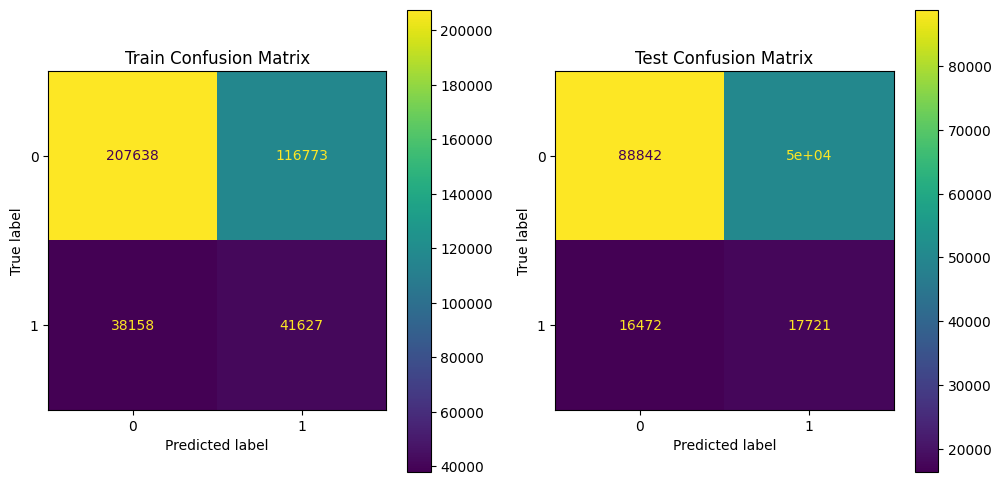

In [39]:
display_confusion_matrix(
    baseline_best_model, X_train, y_train, X_test, y_test)

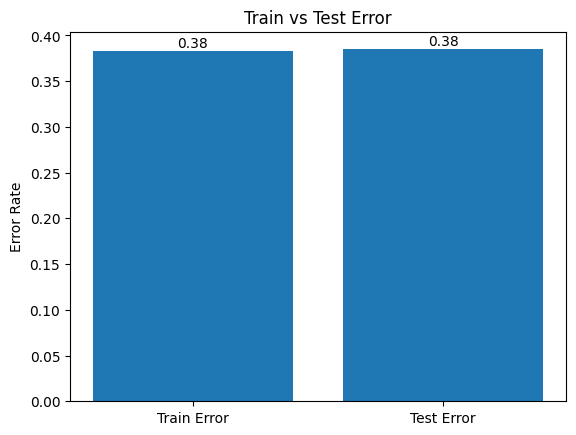

In [40]:
plot_train_vs_test_error(
    baseline_best_model, X_train, y_train, X_test, y_test)

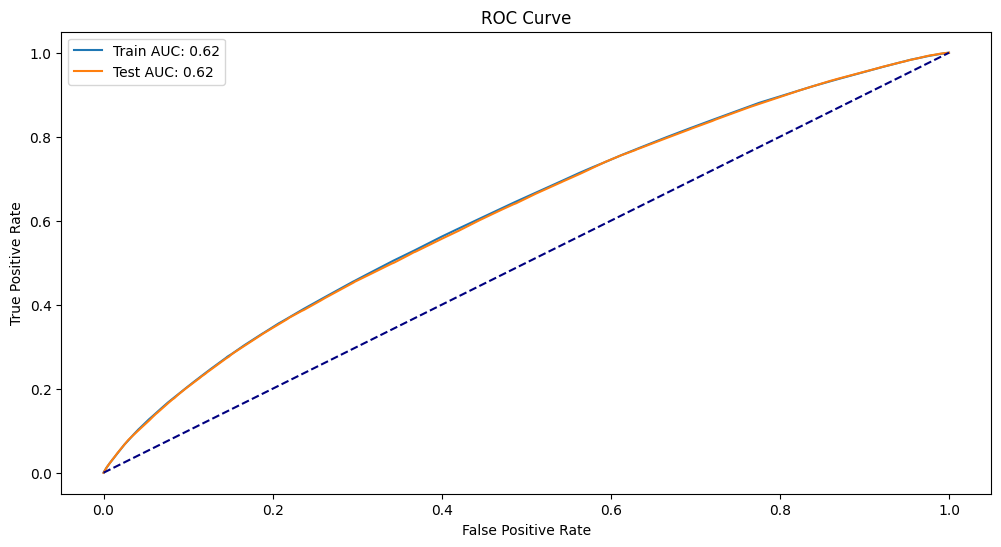

In [41]:
plot_roc_curve(baseline_best_model, X_train,
               y_train, X_test, y_test)

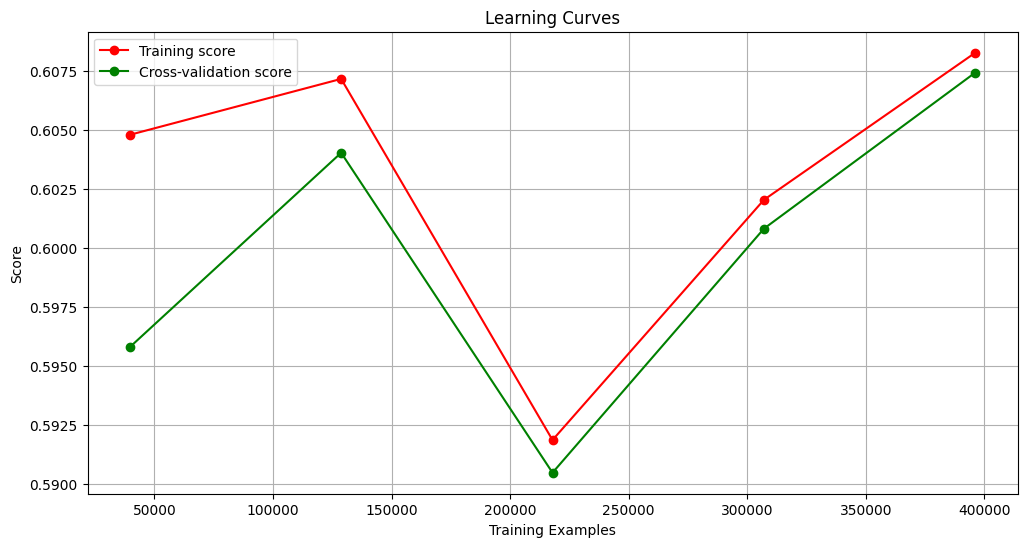

In [42]:
plot_model_learning_curve(baseline_best_model, X_train, y_train)

The metrics for our initial model are satisfactory, but we will still proceed with hyperparameter tuning to further improve the model's performance.

In [43]:
algo_baseline_df.to_csv('../reports/algo_baseline_model.csv', index = False)

In [44]:
with open('../models/baseline_best_model.pkl', 'wb') as file:
    pickle.dump(baseline_best_model, file)

## 3. Hyperparameters Tuning

### 3.1 Hyperparameters List

#### 3.1.1 Grid Search

In [45]:
xgb_hyperparams = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [46]:
xgb_grid_search = GridSearchCV(
    XGBClassifier(random_state=777, tree_method='hist', device='cuda'),
    xgb_hyperparams,
    n_jobs=-1,
    verbose=420,
    scoring='f1_macro'
)

In [47]:
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=777, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=420)

In [49]:
best_estimator_from_grid = xgb_grid_search.best_estimator_

In [50]:
models_list["fine-tuned"] = [{"model_name": "GridSearchBest-XGBoost",
                              "model_object": best_estimator_from_grid, "model_uid": ""}]

#### 3.1.2 Bayesian Search

In [51]:
xgb_space = {
    'n_estimators': hyperopt.hp.choice('n_estimators', [50, 100, 200]),
    'learning_rate': hyperopt.hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_depth': hyperopt.hp.choice('max_depth', [3, 5, 7]),
    'subsample': hyperopt.hp.uniform('subsample', 0.8, 1.0),
    'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.8, 1.0)
}

In [52]:
def objective(params):
    classifier = XGBClassifier(**params, random_state=777)
    score = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1_macro').mean()
    return {"loss": -score, "status": STATUS_OK}

In [53]:
trials = Trials()
best = fmin(fn=objective,
            space=xgb_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
best_params = space_eval(xgb_space, best)

100%|██████████| 100/100 [10:31<00:00,  6.32s/trial, best loss: -0.445700376178036]


In [54]:
print("The best parameters are: ", best_params)

The best parameters are:  {'colsample_bytree': 0.9330239002792108, 'learning_rate': 0.15499993360234732, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9545353884492025}


In [55]:
optimal_xgb = XGBClassifier(**best_params, random_state=777)

In [56]:
models_list["fine-tuned"].append({"model_name": "BayesOpt-XGBoost",
                                  "model_object": optimal_xgb, "model_uid": ""})

### 3.2 Best Model Hyperparameter Retraining

In [58]:
training_log, models_list_tuned = model_training_and_evaluation(
    models_list["fine-tuned"],
    "tuned_model",
    X_train,
    y_train,
    X_test,
    y_test,
    "tuned",
    '../models/logs/training_log.json'
)

100%|██████████| 2/2 [00:05<00:00,  2.86s/it]

Logs Before Training: 1
Logs After Training: 2
Added 1 new logs.


In [59]:
models_list

{'vanilla': [{'model_name': 'vanilla-vanilla_LogisticRegression-fold_1',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': 'e63ae0dfc7b802fda2e8097728ffc75f'},
  {'model_name': 'vanilla-vanilla_LogisticRegression-fold_2',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': 'b955eab570f64b54d720a6e45c7123f5'},
  {'model_name': 'vanilla-vanilla_LogisticRegression-fold_3',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': '1a0700d2198e471f308cd45e966e51b4'},
  {'model_name': 'vanilla-vanilla_LogisticRegression-fold_4',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': '029d06903d7e5a99bac03aa4a451a3ad'},
  {'model_name': 'vanilla-vanilla_LogisticRegression-fold_5',
   'model_object': LogisticRegression(class_weight='balanced', random_state=777),
   'model_uid': 'e901609a5967055b316b6f188a239814'},
  {'

### 3.3 Hyperparameter-tuned Model Performance Review

In [60]:
all_training_logs_df_tuned = training_log_to_df_converter(training_log)
all_training_logs_df_tuned

100%|██████████| 2/2 [00:00<00:00, 264.32it/s]


,model_name,model_uid,training_time,training_date,f1_score_avg,auc_roc,gini,data_configurations,accuracy,0.precision,...,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,vanilla-vanilla_XGBClassifier-fold_4,0c8cece672122af336c13a092d9c4806,1.105984,2024-08-15 12:42:56.456359,0.538970,0.616119,0.232239,vanilla,0.617549,0.844264,...,0.348637,22795.0,0.553431,0.580217,0.538970,115484.0,0.729451,0.617549,0.654165,115484.0
1,vanilla-vanilla_XGBClassifier-fold_1,7fbe64f6732fd6bd993e9cf2692b6b90,1.210205,2024-08-15 12:42:52.293107,0.533882,0.617268,0.234536,vanilla,0.606183,0.845707,...,0.350304,22796.0,0.552720,0.580422,0.533882,115485.0,0.730039,0.606183,0.644985,115485.0
2,vanilla-vanilla_XGBClassifier-fold_2,29f28fb76e20e0a6c16ea10b8b247212,1.207557,2024-08-15 12:42:53.709505,0.532142,0.615641,0.231283,vanilla,0.602606,0.846053,...,0.350574,22796.0,0.552405,0.580278,0.532142,115485.0,0.730124,0.602606,0.642030,115485.0
3,vanilla-vanilla_XGBClassifier-fold_5,a8064182c29250061456c3887bea27bc,1.134672,2024-08-15 12:42:57.752791,0.531714,0.612948,0.225896,vanilla,0.604586,0.843996,...,0.346985,22795.0,0.550698,0.577302,0.531714,115484.0,0.728210,0.604586,0.643517,115484.0
4,vanilla-vanilla_XGBClassifier-fold_3,a926732d4e235d899c7b317a846baeba,1.141120,2024-08-15 12:42:55.123747,0.528502,0.614178,0.228356,vanilla,0.597229,0.845172,...,0.348489,22796.0,0.550575,0.577805,0.528502,115485.0,0.728869,0.597229,0.637448,115485.0
5,vanilla-vanilla_LogisticRegression-fold_4,029d06903d7e5a99bac03aa4a451a3ad,0.319055,2024-08-15 12:42:51.487184,0.495987,0.603390,0.206780,vanilla,0.536923,0.851940,...,0.352347,22795.0,0.547647,0.575095,0.495987,115484.0,0.731813,0.536923,0.582921,115484.0
6,vanilla-vanilla_LogisticRegression-fold_2,b955eab570f64b54d720a6e45c7123f5,0.303404,2024-08-15 12:42:50.679282,0.494291,0.602677,0.205354,vanilla,0.534814,0.851136,...,0.351137,22796.0,0.546706,0.573588,0.494291,115485.0,0.730951,0.534814,0.580929,115485.0
7,vanilla-vanilla_LogisticRegression-fold_1,e63ae0dfc7b802fda2e8097728ffc75f,0.295876,2024-08-15 12:42:50.306611,0.494197,0.606394,0.212788,vanilla,0.533723,0.852594,...,0.352804,22796.0,0.547783,0.575241,0.494197,115485.0,0.732258,0.533723,0.579771,115485.0
8,vanilla-vanilla_LogisticRegression-fold_5,e901609a5967055b316b6f188a239814,0.268653,2024-08-15 12:42:51.888572,0.493273,0.602886,0.205772,vanilla,0.532602,0.852132,...,0.352102,22795.0,0.547249,0.574388,0.493273,115484.0,0.731772,0.532602,0.578713,115484.0
9,vanilla-vanilla_LogisticRegression-fold_3,1a0700d2198e471f308cd45e966e51b4,0.362109,2024-08-15 12:42:51.054398,0.492904,0.601773,0.203546,vanilla,0.533186,0.850339,...,0.349981,22796.0,0.545830,0.572194,0.492904,115485.0,0.730122,0.533186,0.579403,115485.0


#### 3.3.1 Grid Searched Model Performance Review

In [61]:
models_dict_tuned = {"fine-tuned": models_list_tuned}
tuned_best_model = tuned_model_finder(
    models_dict_tuned["fine-tuned"], "GridSearchBest")
tuned_best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=777, ...)

In [62]:
metrics_df = get_metrics_dataframe(
    tuned_best_model, X_train, y_train, X_test, y_test)
metrics_df

,precision,recall,f1-score,accuracy,auc_roc,gini,dataset
0,0.746474,0.802625,0.715212,0.802625,0.617912,0.235825,Train
1,0.740153,0.802600,0.715091,0.802600,0.613810,0.227621,Test


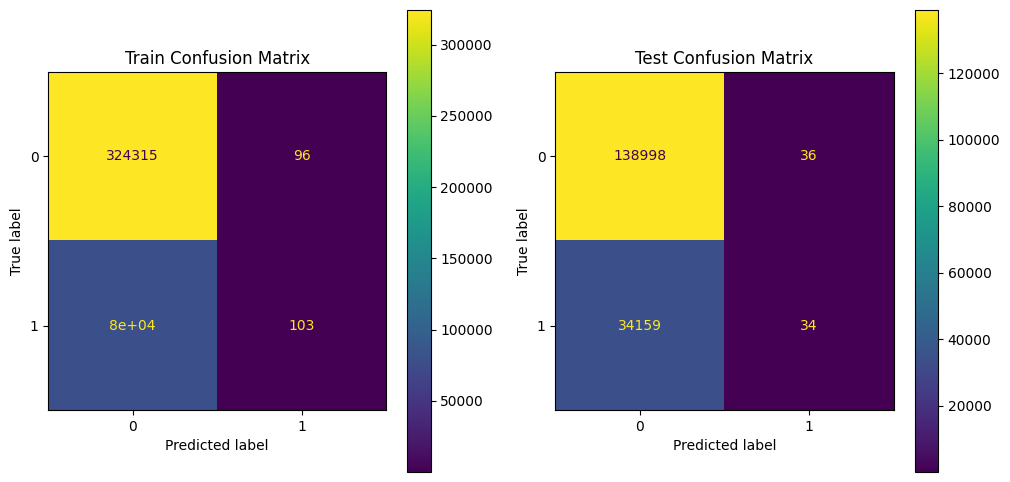

In [63]:
display_confusion_matrix(
    tuned_best_model, X_train, y_train, X_test, y_test)

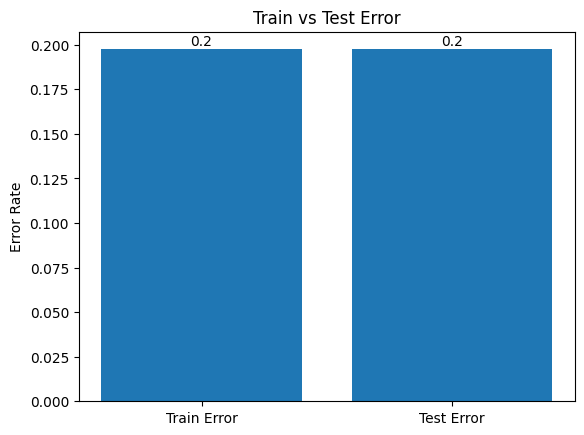

In [64]:
plot_train_vs_test_error(
    tuned_best_model, X_train, y_train, X_test, y_test)

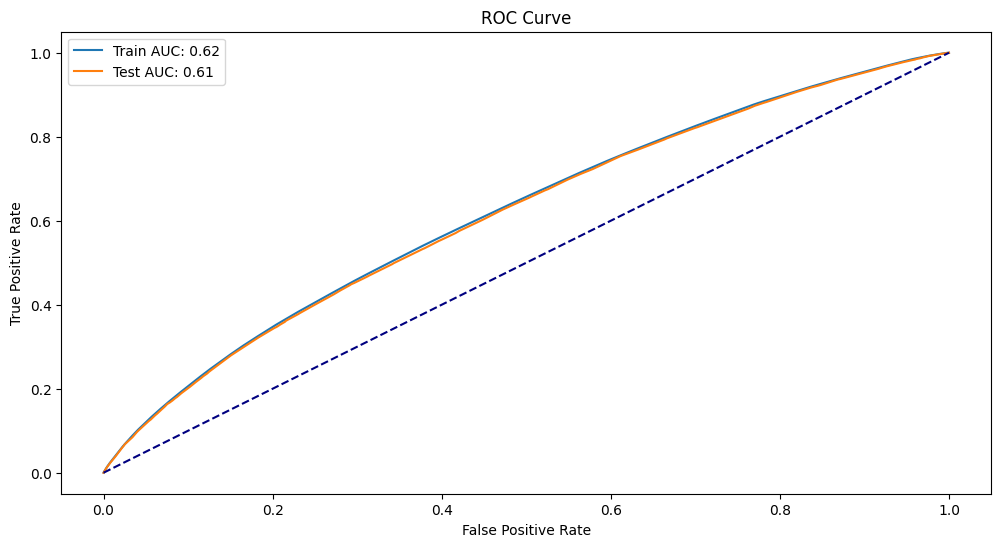

In [65]:

plot_roc_curve(tuned_best_model, X_train,
               y_train, X_test, y_test)

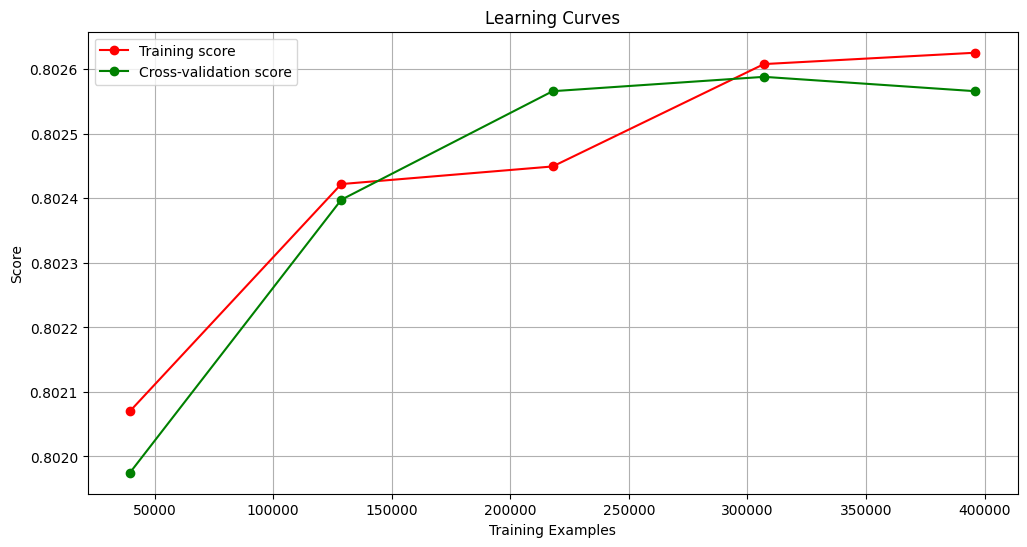

In [66]:
plot_model_learning_curve(tuned_best_model, X_train, y_train)

#### 3.3.2 Bayesian Searched Model Performance Review

In [67]:
models_dict_tuned = {"fine-tuned": models_list_tuned}
tuned_best_model = tuned_model_finder(
    models_dict_tuned["fine-tuned"], "BayesOpt")
tuned_best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9330239002792108, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15499993360234732,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=777, ...)

In [68]:
metrics_df = get_metrics_dataframe(
    tuned_best_model, X_train, y_train, X_test, y_test)
metrics_df

,precision,recall,f1-score,accuracy,auc_roc,gini,dataset
0,0.747732,0.802623,0.715033,0.802623,0.617693,0.235386,Train
1,0.742944,0.802612,0.714977,0.802612,0.613963,0.227927,Test


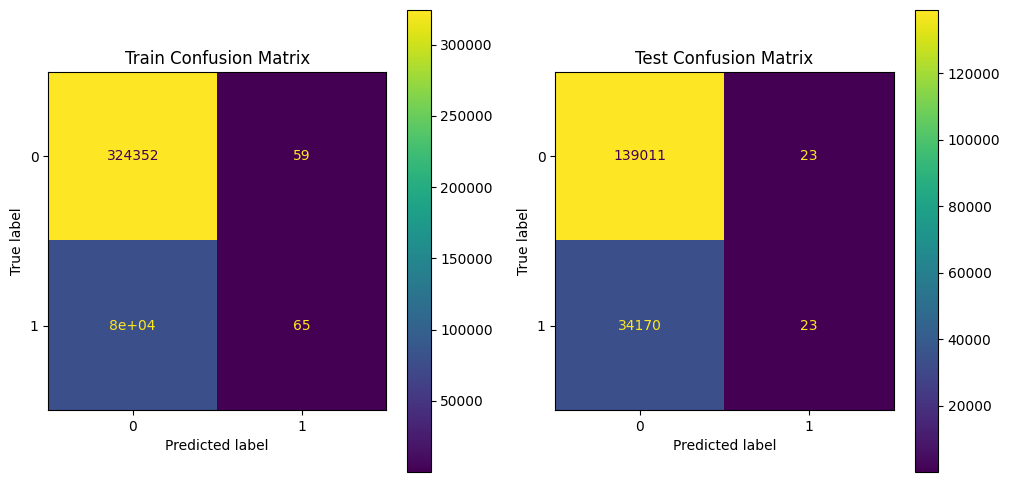

In [69]:
display_confusion_matrix(
    tuned_best_model, X_train, y_train, X_test, y_test)

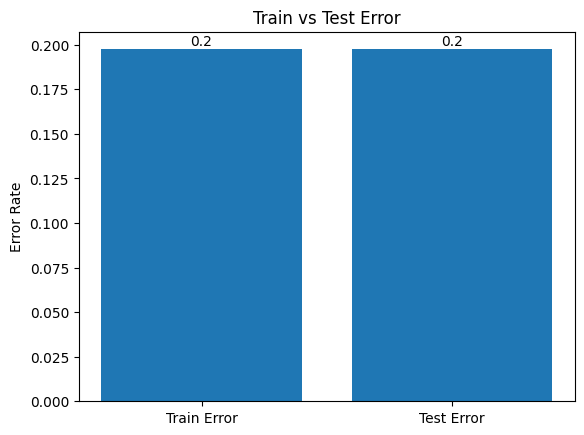

In [70]:
plot_train_vs_test_error(
    tuned_best_model, X_train, y_train, X_test, y_test)

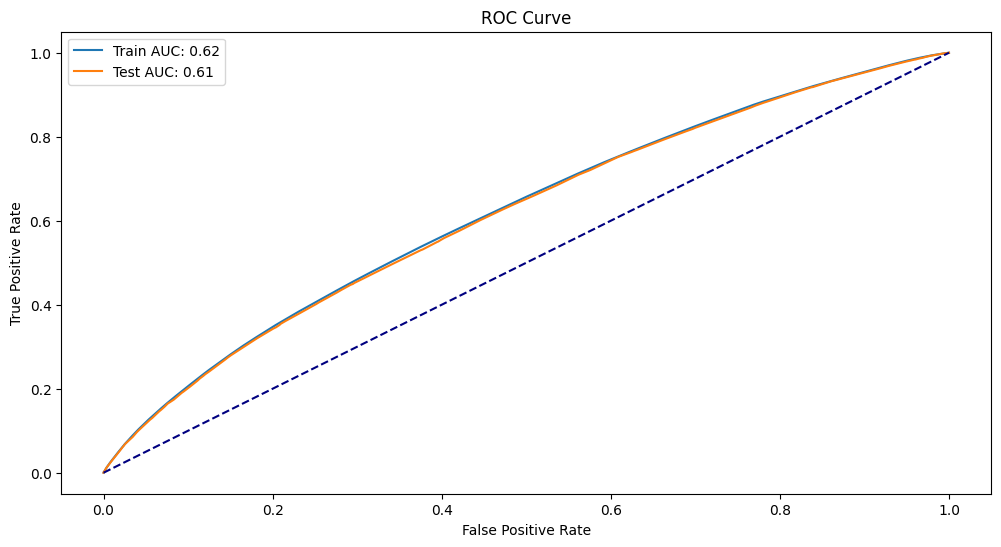

In [71]:
plot_roc_curve(tuned_best_model, X_train,
               y_train, X_test, y_test)

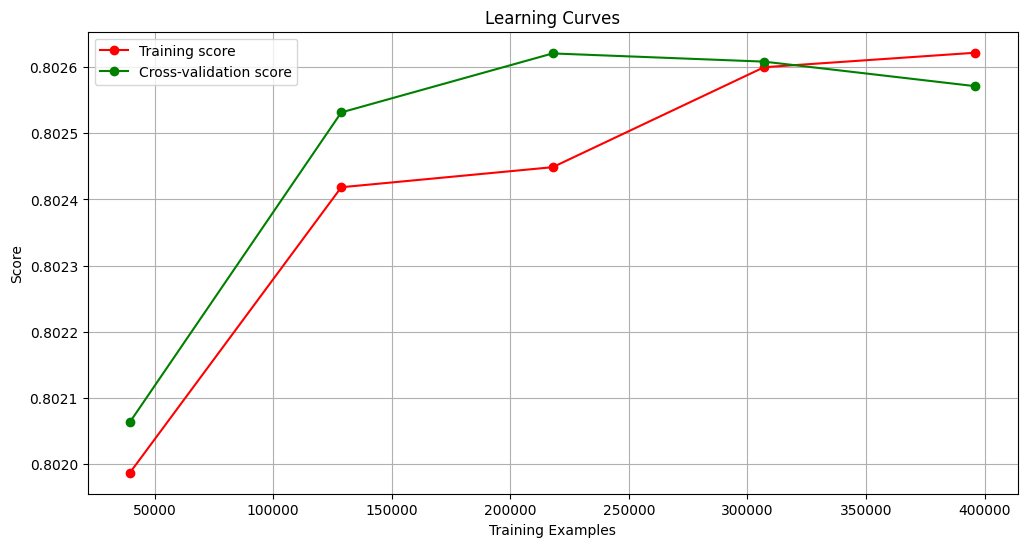

In [72]:
plot_model_learning_curve(tuned_best_model, X_train, y_train)

# E. Prediction Testing

In [81]:
data_instance = X_test.iloc[22, :]
data_instance_reshaped = data_instance.values.reshape(1, -1)
probability = algo_best_model.predict_proba(data_instance_reshaped)
probability_bad_class = probability[0][1]
print(f"Predicted probability of being bad: {probability_bad_class}")

predicted_class = algo_best_model.predict(data_instance_reshaped)
print(f"Predicted class: {predicted_class[0]}")

Predicted probability of being bad: 0.7112067937850952
Predicted class: 1


Logic for  _'isFunded'_ and _'loanStatus'_:
  - Good Loans (Label = 0):
    - Funded and Good Status:
      - If _'isFunded'_ = 1 (Good) and _'loan_status_grouping'_ = 0 (Good):
        - The loan is funded and has a positive outcome, so it's labeled as Good.
    - Not Funded and Neutral Status:
      - If _'isFunded'_ = 0 (Bad) but the loan status indicates a neutral outcome (e.g., Withdrawn Application):
        - The loan didn't go through but wasn't outright rejected, so it can be considered Good.
  - Bad Loans (Label = 1):
    - Funded but Bad Status:
      - If _'isFunded'_ = 1 (Good) but _'loan_status_grouping'_ = 1 (Bad):
        - The loan was funded but has a negative outcome, so it's labeled as Bad.
    - Not Funded and Bad Status:
      - If _'isFunded'_ = 0 (Bad) and _'loan_status_grouping'_ = 1 (Bad):
        - The loan wasn't funded and had a bad outcome (e.g., Rejected), so it's labeled as Bad.
    - Not Funded but Good Status:
      - If _'isFunded'_ = 0 (Bad) but _'loan_status_grouping'_ = 0 (Good):
        - The loan was not funded, but since the status is positive, we can be more lenient and consider it Good (adjusting to balance).

In [13]:
data_instance = X_test.iloc[70, :]
data_instance

loanAmount    0.010182
state         0.203332
leadType     -0.056280
leadCost     -0.016043
Name: 312112, dtype: float64